In [61]:
import scipy
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageOps
from copy import copy, deepcopy
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import os
import glob
from PIL import Image, ImageOps
from scipy import ndimage, misc
import scipy.misc
from skimage.restoration import denoise_tv_chambolle
from sklearn.mixture import GaussianMixture
import statistics

In [37]:
def median_filter(image, kernel_size):
    """Apply a median filter to an image.
    
    Parameters
    ----------
    image : array_like
        Input image.
    kernel_size : int
        Size of the median filter kernel.
    
    Returns
    -------
    image_filtered : array_like
        Filtered image.
    """

    assert kernel_size % 2 == 1 # Kernel size must be odd
    assert kernel_size > 1 #Kernel size must be greater than 1

    return scipy.ndimage.median_filter(image, kernel_size)

# Pipeline is: 
### Pre-processing: histogram equalization --> median filter/gray matter subtraction --> total variation
### Segmentation: gaussian mixture Model --> parameter estimation
### Post-processing: intensity and area constraint --> midline Patter Matching --> bright objects and edge removal

# Load the Image(s)

In [38]:
# load in every image in a given folder


path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'  # point to correct folder

# cur_num represents patient number - used for finding them in directory
cur_num = 49
images = []

# 81 patients in total
for patient in range(81):
    # get filenames for each patient
    filenames = glob.glob(path + "0" + str(cur_num) + "/brain/" + "*.jpg")

    # get each scan for each patient
    for f in filenames:

        # read in the image
        img = cv2.imread(f)
        images.append(img)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #print(Image.fromarray(img))

        cur_num += 1
# to access each image: plt.imshow(images[50], cmap='gray')

# Single Raw Image 

(-0.5, 649.5, 649.5, -0.5)

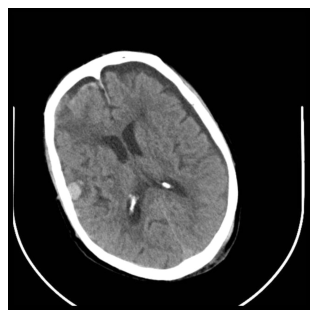

In [39]:
figure(figsize=(5, 5), dpi=80)
im = plt.imread(path+ '092/brain/20.jpg')
plt.imshow(im, cmap='gray')
plt.axis('off')

# Preprocessing

## Histogram Equalization

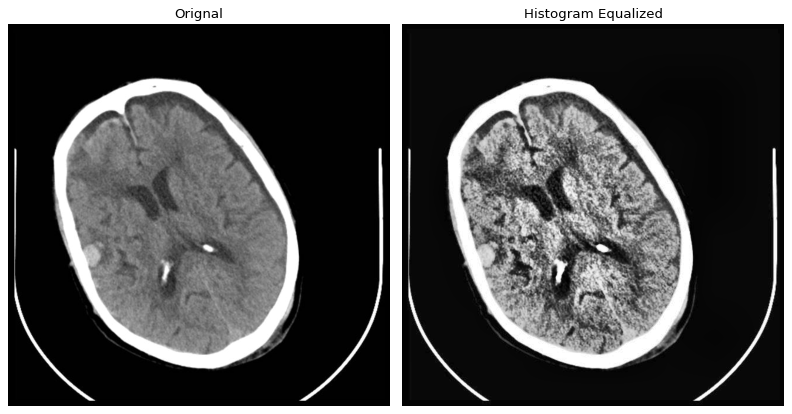

In [41]:
im = cv2.imread(path+ '092/brain/20.jpg',0) # YOU NEED THE 0 IN FOR THIS TO WORK 
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# special histogram equalization where picture is broken up into blocks, equalized separately, 
# and then put back together

clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8)) # histogram equalization parameters
he_im = clahe.apply(im) # apply the histogram equalization to the image (im)
#cv2.imwrite('res.jpg', res)

#res = np.hstack((im,final_image))
figure(figsize=(10, 8), dpi=80)
#plt.imshow(res, cmap="gray")
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.tight_layout()

## Median Filter 

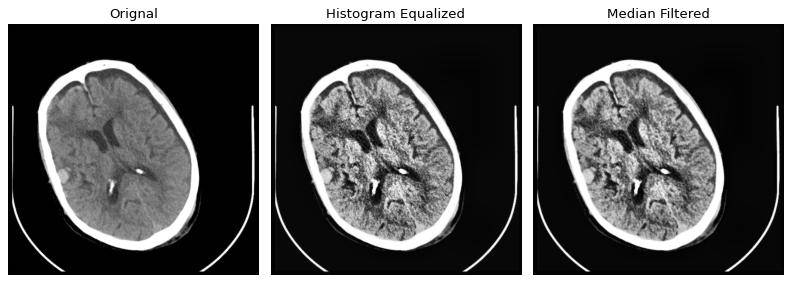

In [42]:
#Image.fromarray(median_filter(im,3))
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(1,3,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')

# median filter
med_im = median_filter(he_im,3)
plt.subplot(1,3,3)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')
plt.tight_layout()

### Exploration: Median Filtered Image - Orignal 

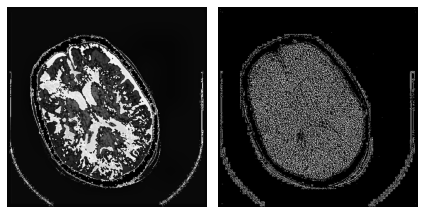

In [43]:
plt.subplot(1,2,1)
plt.imshow(med_im-im, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(med_im-he_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()

## Gray matter subtraction (GMS): 
In this stage the gray matter intensity is removed from the image by subtracting the maximum intensity level of the histogram from the image. 

10


(-0.5, 649.5, 649.5, -0.5)

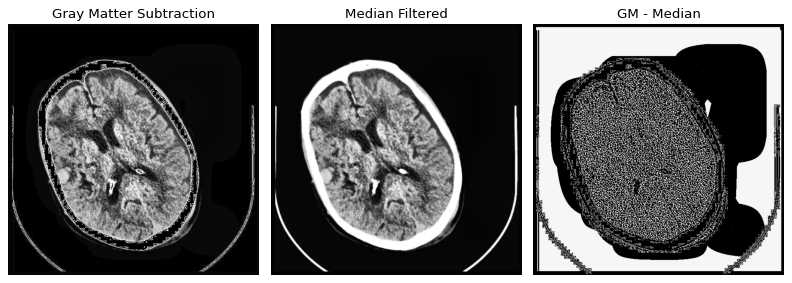

In [75]:
flat_he_im = he_im.flatten()
max_intens = statistics.mode(flat_he_im)
print(max_intens)

mask = (he_im != max_intens)
mask2 = (he_im != 255)
gms_im = he_im*mask*mask2
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,3,1)
plt.imshow(gms_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.title('Gray Matter Subtraction')

plt.subplot(1,3,2)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gms_im-med_im, cmap='gray')
plt.title('GM - Median')
plt.axis('off')

## Total Variation 

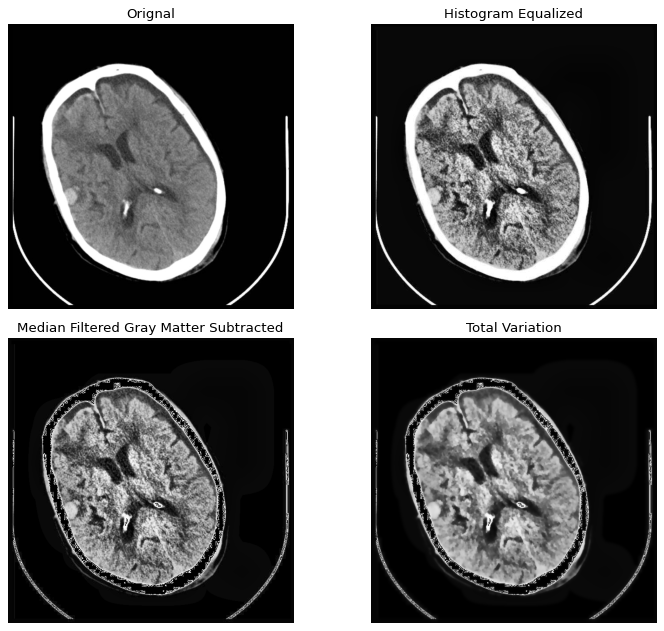

In [76]:
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(gms_im, cmap='gray')
plt.title('Median Filtered Gray Matter Subtracted')
plt.axis('off')

# total variation
tv_im = denoise_tv_chambolle(gms_im, weight=0.1)
# The greater weight, the more denoising (at the expense of fidelity to input).
plt.subplot(2,2,4)
plt.title('Total Variation')
plt.imshow(tv_im, cmap='gray')
plt.axis('off')
plt.tight_layout()

### How total variation changed from original image and last step 

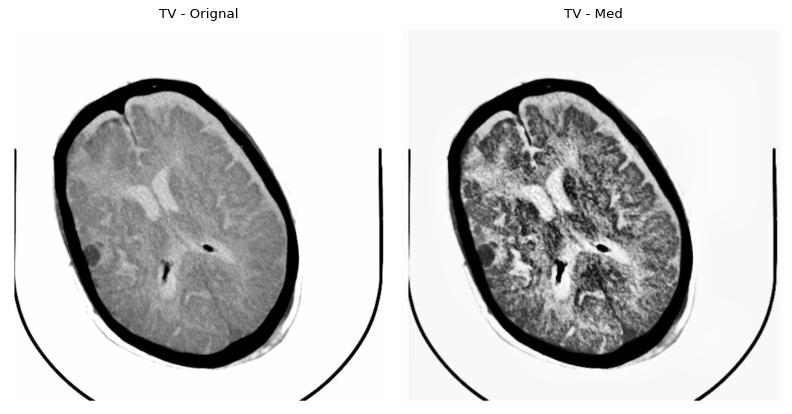

In [77]:
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,2,1)
plt.imshow(tv_im-im, cmap = 'gray')
plt.title('TV - Orignal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tv_im-med_im, cmap = 'gray')
plt.title('TV - Med')
plt.axis('off')
plt.tight_layout()

# Segmentation

## Gaussian Mixture Model 
https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_GMM.html

0.14936863640791465


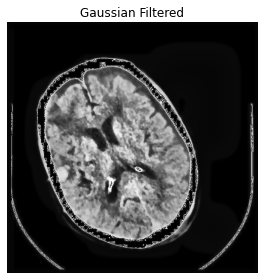

In [99]:
#l = 256
#n = 10
g_im = ndimage.gaussian_filter(tv_im, 2)
plt.imshow(tv_im, cmap='gray')
plt.title('Gaussian Filtered')
plt.axis('off')
plt.tight_layout()
print(np.max(tv_im-im))

In [100]:
mask = (g_im > g_im.mean()).astype(np.float)

gmm_img = mask + 0.3*np.random.randn(*mask.shape)

hist, bin_edges = np.histogram(gmm_img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

classif = GaussianMixture(n_components=2)
classif.fit(gmm_img.reshape((gmm_img.size, 1)))

threshold = np.mean(classif.means_)
binary_img = gmm_img > threshold

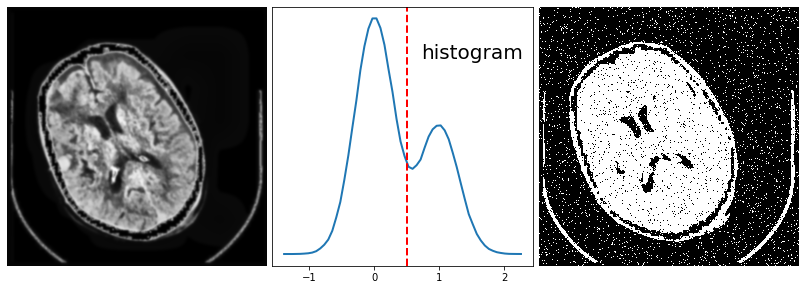

In [101]:
plt.figure(figsize=(11,4))

plt.subplot(131)
plt.imshow(g_im, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.plot(bin_centers, hist, lw=2)
plt.axvline(0.5, color='r', ls='--', lw=2)
plt.text(0.57, 0.8, 'histogram', fontsize=20, transform = plt.gca().transAxes)
plt.yticks([])
plt.subplot(133)
plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

In [108]:
np.median(g_im)

0.03316030771273794

In [103]:
np.max(g_im)

0.9325391311506903

In [107]:
print(np.max(g_im)-np.min(g_im))

0.9325391311506903
